In [ ]:
import numpy as np

# packages for plotting
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9',
            'grid.color' : '#AAAAAA',
            'axes.edgecolor':'#333333',
            'figure.facecolor':'#FFFFFF',
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   ,
            'figure.dpi': 300
           })

#### MLP (with early stopping, 2 hidden layers with ReLU)

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    Din: int = 50 # dim of features
    hidden_dim: int = 64
    batchsize: int = 32
    datasize: int = 6400
    split: float = 0.1 # 10/10/80 test val train
    epochs: int = 60
    lr: float = 0.001
    patience: int = 5
    min_delta: float = 1e-4 # for early stopping

    # need to put here threshold & lower/upper region for 'sensitive' region

config = Config()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

class bigMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(bigMLP, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)


    def forward(self,x):
        #actv = torch.nn.ReLU()
        actv = torch.nn.LeakyReLU()
        h = actv(self.fc1(x))
        h = actv(self.fc2(h))
        h = actv(self.fc3(h))
        h = self.fc4(h)
        return h.squeeze()

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        # fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)


    def forward(self,x):
        h = torch.relu(self.fc1(x))
        h = self.fc2(h)
        return h.squeeze()

def weights_init_uniform(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

#------ MLP 1: generative model ------#

def generatedata(Din, hidden_dim=64, num_samples=500):
    # generate data points with the dimensionality of Din
    gen_model = MLP(Din,hidden_dim)
    gen_model.apply(weights_init_uniform)
    gen_model.eval()
    with torch.no_grad():
        features = torch.torch.distributions.Uniform(low=-2, high=2).sample((num_samples,Din))
        labels = gen_model(features) + torch.normal(0., 0.1, size=(1,num_samples)).squeeze()
    return features, labels

#--------- Noising the data ----------#

def noising(data, xnoiselevel, ynoiselevel, threshold=0, noise_region='above', plot=True):
    x, y = data
    x = x.numpy()
    y = y.numpy()
    x_random = np.random.normal(size=x.shape)
    y_random = np.random.normal(size=y.shape)
    if noise_region == 'above':
        xnoise = xnoiselevel * x_random * np.select([y>threshold],[1], 0).reshape(-1,1)
        ynoise = ynoiselevel * y_random * np.select([y>threshold],[1], 0)
    elif noise_region == 'below':
        xnoise = xnoiselevel * x_random * np.select([y<threshold],[1], 0).reshape(-1,1)
        ynoise = ynoiselevel * y_random * np.select([y<threshold],[1], 0)
    else:
          raise Exception("'targetregion' argument can only accept 'below' or 'above'")
    xn = x + np.float32(xnoise)
    yn = y + np.float32(ynoise)
    if plot:
        if noise_region == 'above':
            mask = y > threshold
            title_suffix = 'y > threshold'
        else:
            mask = y < threshold
            title_suffix = 'y < threshold'
        # to be certain only desired region is noised
        if ynoiselevel:
            # separate non-noised vs noised region by color
            plt.scatter(y[mask], yn[mask], c='C1')
            plt.scatter(y[~mask], yn[~mask], c='C0')
            plt.title(f'Y noise at level {ynoiselevel}')
            plt.tight_layout()
            plt.savefig(f'sanitycheck_yn{xnoiselevel}.png',dpi=300)
            plt.show()

        if xnoiselevel:
            plt.scatter(x[mask, 0], xn[mask, 0], c='C1')
            plt.scatter(x[~mask, 0], xn[~mask, 0], c='C0')
            plt.title(f'X noise at level {xnoiselevel}')
            plt.ylim(-8,8)
            plt.xlim(-2,2)
            plt.ylabel('noised x')
            plt.xlabel('true x')
            plt.tight_layout()
            plt.savefig(f'sanitycheck_xn{xnoiselevel}.png',dpi=300)
            plt.show()


            plt.tight_layout()
            # # Plot a histogram for gaussian noise
            # plt.hist(x_random[:,0], bins=30)
            # plt.title('Distribution of Random Normal Noise (X)')
            # plt.xlabel('Value')
            # plt.ylabel('Frequency')
            # plt.show()

    return torch.tensor(xn), torch.tensor(yn)

#------ MLP 2: the actual model ------#

# early stopping solution from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, verbose=True):
        # it simply looks at validation loss and whether it isn't improving for few steps
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                if verbose:
                    print("Early stopping. No improvement in validation loss.")
                return True
        return False


class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def train(
    model,
    train_data,
    val_data,
    batch_size = config.batchsize,
    num_epochs = config.epochs,
    lr = config.lr,
    earlystop_patience = config.patience,
    earlystop_delta = config.min_delta,
    verbose = True
):
    train_features, train_labels = train_data
    val_features, val_labels = val_data
    model.apply(weights_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopper(patience=earlystop_patience, min_delta=earlystop_delta)
    rmse = RMSELoss()

    losses = []
    val_losses = []
    patience = 0
    for epoch in range(num_epochs):
        model.train()
        trainsize = len(train_features)
        indices = torch.randperm(trainsize)
        total_loss = 0
        for batch_start in range(0,trainsize, batch_size):
            batch_idxs = indices[batch_start: batch_start + batch_size]
            batch_features = train_features[batch_idxs]
            batch_labels = train_labels[batch_idxs]
            # batch_features = train_features[batch_start: batch_start + batch_size]
            # batch_labels = train_labels[batch_start: batch_start + batch_size]

            pred = model(batch_features)
            #loss = F.mse_loss(pred,train_labels)
            loss = rmse(pred,batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (trainsize // batch_size)
        losses.append(avg_loss)

        model.eval()
        with torch.no_grad():
            val_pred = model(val_features)
            val_loss = rmse(val_pred,val_labels)
        val_losses.append(val_loss.item())

        if epoch % 1 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Validation Loss: {val_loss:.4f}')

        if early_stopper.early_stop(val_loss, verbose):
            break
    return losses, val_losses


def local_loss(y,yhat, min, max):
    rmse = RMSELoss()
    mask = (y >= min) & (y <= max)
    local_y = y[mask]
    local_yhat = yhat[mask]
    local_rmse = rmse(local_yhat, local_y)
    return local_rmse.item()


def data_split(data, val_split=0.1, test_split=0.1, random_state=None):
    # split into train, val, and test sets
    if random_state is not None:
        np.random.seed(random_state)

    # Combine the features and labels into a single array
    features, labels = data
    data = np.column_stack((features, labels))
    np.random.shuffle(data)
    test_len = int(len(data) * test_split)
    val_len = int(len(data) * val_split)
    test_data = data[:test_len]
    val_data = data[test_len:test_len + val_len]
    train_data = data[test_len + val_len:]

    # Split the data back into features and labels
    train_features, train_labels = torch.from_numpy(train_data[:, :-1]), torch.from_numpy(train_data[:, -1])
    val_features, val_labels = torch.from_numpy(val_data[:, :-1]), torch.from_numpy(val_data[:, -1])
    test_features, test_labels = torch.from_numpy(test_data[:, :-1]), torch.from_numpy(test_data[:, -1])
    return (train_features, train_labels), (val_features, val_labels), (test_features, test_labels)


def filterdata_by_label(data, threshold, omitregion):
    if omitregion not in ['above', 'below']:
        raise ValueError("omitregion must be either 'above' or 'below'")
    x,y = data
    filtered_x = []
    filtered_y = []

    for i, label in enumerate(y):
        if omitregion == 'above':
            if label < threshold:
                filtered_x.append(x[i])
                filtered_y.append(label)
        else:
            if label > threshold:
                filtered_x.append(x[i])
                filtered_y.append(label)

    if len(filtered_x) == 1:
        filtered_x = filtered_x[0]
    else:
        x_shape = filtered_x[0].shape
        filtered_x = torch.stack(filtered_x).reshape(len(filtered_x), *x_shape)

    if len(filtered_y) == 1:
        filtered_y = filtered_y[0]
    else:
        filtered_y = torch.tensor(filtered_y)

    return filtered_x, filtered_y

def setseed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.Generator().manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)



In [ ]:
def omit_sensitive_data(data, threshold, sensitive_region, omit_probability=1, plot=False):
    """
    Filters and returns data by omitting a fraction of data in the sensitive region.

    Args:
    data (tuple): Input data containing features and labels.
    threshold (float): Value determining the sensitive region.
    sensitive_region (str): 'above' or 'below' to specify the sensitive region.
    omit_probability (float): Chance of omitting a data point in the sensitive region (between 0 and 1).
    plot (boolean): Prints a plot of filtered y vs. raw y for sanity check.

    Returns:
    tuple: Filtered features and labels as tensors.

    """
    if sensitive_region not in ['above','below']:
        raise ValueError("sensitive_region must be either 'above' or 'below'")
    if not 0 <= omit_probability <= 1:
        raise ValueError("omit_probability must be in the range [0,1]")

    x, y = data
    filtered_x = []
    filtered_y = []
    for i, label in enumerate(y):
        is_in_sensitive_region = (
            (sensitive_region == 'above' and label.item() > threshold) or
            (sensitive_region == 'below' and label.item() < threshold)
        )
        if is_in_sensitive_region and torch.rand(1).item() <= omit_probability:
            # exclude this data point if it's in sensitive region and within omission probability
            continue

        filtered_x.append(x[i])
        filtered_y.append(label)

    # Convert back to tensors, preserving original data types and shapes
    filtered_x = torch.stack(filtered_x)
    filtered_y = torch.tensor(filtered_y, dtype=y.dtype)

    if plot:
        plt.figure()
        plt.plot(y.numpy(), color='blue', label='Original Y Values')
        plt.plot(filtered_y.numpy(), color='red', label='Filtered Y Values')
        plt.axhline(y=threshold, color='grey', linestyle='--', label='Threshold')
        plt.xlabel('Index') # filter_y indices doesn't refer to the original y...
        plt.ylabel('Y Value')
        plt.title('Sensitive Data Omission')
        plt.legend()
        plt.show()

    return filtered_x, filtered_y

In [ ]:
def mlptask_wrapper(seed, tasks, sensitive_threshold=0, sensitive_region='above', verbose=False, sanitycheckplot=False):
    """
    This wrapper function executes a series of training tasks on separate MLP models.
    'tasks' is input list of tuples containing task configurations, where each tuple consists of
        task_name (string): name of the task
        xnoise (float): gaussian noise level applied to features in sensitive region
        ynoise (float): gaussian noise level applied to labels in sensitive region
        omit (boolean): to omit the sensitive region

    Returns:
        results (dictionary): Contains dictionaries of training losses, validation losses, predictions, and y values of
            the test set, test errors for below and above 'sensitive' threshold.
    """

    # generate data
    setseed(seed + 1)
    data = generatedata(config.Din, config.hidden_dim, config.datasize)
    features, labels = data
    traindata, valdata, testdata = data_split(data, val_split=config.split, test_split=config.split, random_state=seed)
    x_test, y_test = testdata
    y_min = y_test.min().item()
    y_max = y_test.max().item()

    all_losses = {}
    all_val_losses = {}
    all_preds = {}
    lower_error = {}
    upper_error = {}
    x_levels = {}
    y_levels = {}
    omission = {}
    # #results = {}
    for task_name, xnoise, ynoise, omit in tasks:
        setseed(seed)
        model = MLP(config.Din, config.hidden_dim)
        task_traindata = traindata
        task_valdata = valdata

        if omit:
            # task_traindata = filterdata_by_label(traindata, threshold=sensitive_threshold, omitregion=sensitive_region)
            # task_valdata = filterdata_by_label(valdata, threshold=sensitive_threshold, omitregion=sensitive_region)
            task_traindata = omit_sensitive_data(
                traindata, threshold=sensitive_threshold, sensitive_region=sensitive_region, omit_probability=1, plot=sanitycheckplot
            )
            task_valdata = omit_sensitive_data(
                valdata, threshold=sensitive_threshold, sensitive_region=sensitive_region, omit_probability=1, plot=False
            )

        elif xnoise or ynoise:
            task_traindata = noising(traindata, xnoise, ynoise, sensitive_threshold, plot=sanitycheckplot)
            task_valdata = noising(valdata, xnoise, ynoise, sensitive_threshold, plot=False)

        x_levels[task_name] = xnoise
        y_levels[task_name] = ynoise
        omission[task_name] = omit

        # # losses, val_losses = train(model, task_traindata, task_valdata, verbose=verbose)
        # # model.eval()
        # # with torch.no_grad():
        # #     preds = model(x_test)

        # # # calculate test errors for labelled regions above/below the 'sensitive' threshold
        # # lower_error = local_loss(y_test, preds, y_min, sensitive_threshold) # below sensitive threshold
        # # upper_error = local_loss(y_test, preds, sensitive_threshold, y_max) # above

        # # results[task_name] = {
        # #     'x_noise_level': xnoise,
        # #     'y_noise_level': ynoise,
        # #     'omit': omit,
        # #     'train_loss': losses,
        # #     'val_loss': val_losses,
        # #     'pred': preds,
        # #     'y_test': y_test,
        # #     'lower_error': lower_error,
        # #     'upper_error': upper_error,
        # # }

        all_losses[task_name], all_val_losses[task_name] = train(model, task_traindata, task_valdata, verbose=verbose)
        model.eval()
        with torch.no_grad():
            preds = model(x_test)
        all_preds[task_name] = preds

        # calculate test errors for labelled regions above/below the 'sensitive' threshold
        lower_error[task_name] = local_loss(y_test, preds, y_min, sensitive_threshold)
        upper_error[task_name] = local_loss(y_test, preds, sensitive_threshold, y_max)

    results = {
        'x_noise_level': x_levels,
        'y_noise_level': y_levels,
        'omit': omission,
        'train_loss': all_losses,
        'val_loss': all_val_losses,
        'pred': all_preds,
        'y_test': y_test,
        'lower_error': lower_error,
        'upper_error': upper_error,

    }
    return results

# example of tasks
tasks = [
    ('baseline', 0, 0, False),
    ('omission', 0, 0, True),
    ('x noise', 2.0, 0, False),
    ('y noise', 0, 1.0, False),
]


In [ ]:
# Right now the plotting functions can only plot up to 4 tasks
# may need to adjust it... Need to figure out how to set optimal figsize

def plot_trainingcurves(tasks, results, figname=""):
    all_losses = results['train_loss']
    all_val_losses = results['val_loss']

    fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, dpi=300 ,figsize=(12,3))
    axs = axs.flatten()
    for i, task in enumerate(tasks):
        if i > 3:
          print("Can only plot up to 4 tasks")
          break
        task_name = task[0]
        ax = axs[i]
        ax.plot(all_losses[task_name])
        ax.plot(all_val_losses[task_name])
        ax.set_title(task_name)
        ax.set_xlabel('epoch')
        ax.set_ylabel('RMSE')
    plt.tight_layout()
    if figname:
        plt.savefig(figname,dpi=300)


def plot_parityplots(tasks, results, threshold=0, figname=""):
    y_test = results['y_test']
    fig, axs = plt.subplots(nrows=1, ncols=4, sharey=False, dpi=300 ,figsize=(12,3))
    axs = axs.flatten()
    for i, task in enumerate(tasks):
        if i > 3:
          print("Can only plot up to 4 tasks")
          break
        task_name = task[0]
        ax = axs[i]
        preds = results['pred'][task_name]
        lower_error = results['lower_error'][task_name]
        upper_error = results['upper_error'][task_name]

        above_threshold = y_test >= threshold
        below_threshold = y_test < threshold

        #ax.scatter(y_test, preds, s=10, alpha=0.5)
        ax.scatter(y_test[below_threshold], preds[below_threshold], s=10, alpha=0.5)
        ax.scatter(y_test[above_threshold], preds[above_threshold], s=10, alpha=0.5)


        ax.plot([-10,10],[-10,10])
        ax.plot([threshold,threshold],[-10,10],'--',alpha=0.5, c='C2')
        ax.set_xlim(-10,10)
        ax.set_ylim(-10,10)
        ax.text(-5,-9,f'rmse:\n{lower_error:.3f}', horizontalalignment='center')
        ax.text(5,7,f'rmse:\n{upper_error:.3f}', horizontalalignment='center')
        ax.set_xlabel('true labels')
        ax.set_ylabel('predicted labels')
        ax.set_title(task_name)
    plt.tight_layout()
    if figname:
        plt.savefig(figname,dpi=300)

def create_dataframe(full_results):
    # filter results then create DataFrame
    # TODO: this assumes the sensitive region is above the sensitivity threshold - will need to update the code
    data = {}
    data['x noise'] = full_results['x_noise_level']
    data['y noise'] = full_results['y_noise_level']
    data['omit?'] = full_results['omit']
    data['% omitted'] = full_results.get('omit_fraction')  # This will be None if 'omit_fraction' happens to not exist
    data['s=0 RMSE'] = full_results['lower_error']
    data['s=1 RMSE'] = full_results['upper_error']

    return pd.DataFrame.from_dict(data)

##### results for main MLP figure (baseline, omission, x-noise, y-noise) -- ran in aug 2024

In [ ]:
seed = 511
tasks = [
    ('no perturbation', 0, 0, False),
    ('omission', 0, 0, True),
    ('x noise (2.0)', 2.0, 0, False),
    ('y noise (1.5)', 0, 1.5, False)
]

main_results = mlptask_wrapper(seed, tasks, sensitive_threshold=2, sensitive_region='above', verbose=False, sanitycheckplot=False)

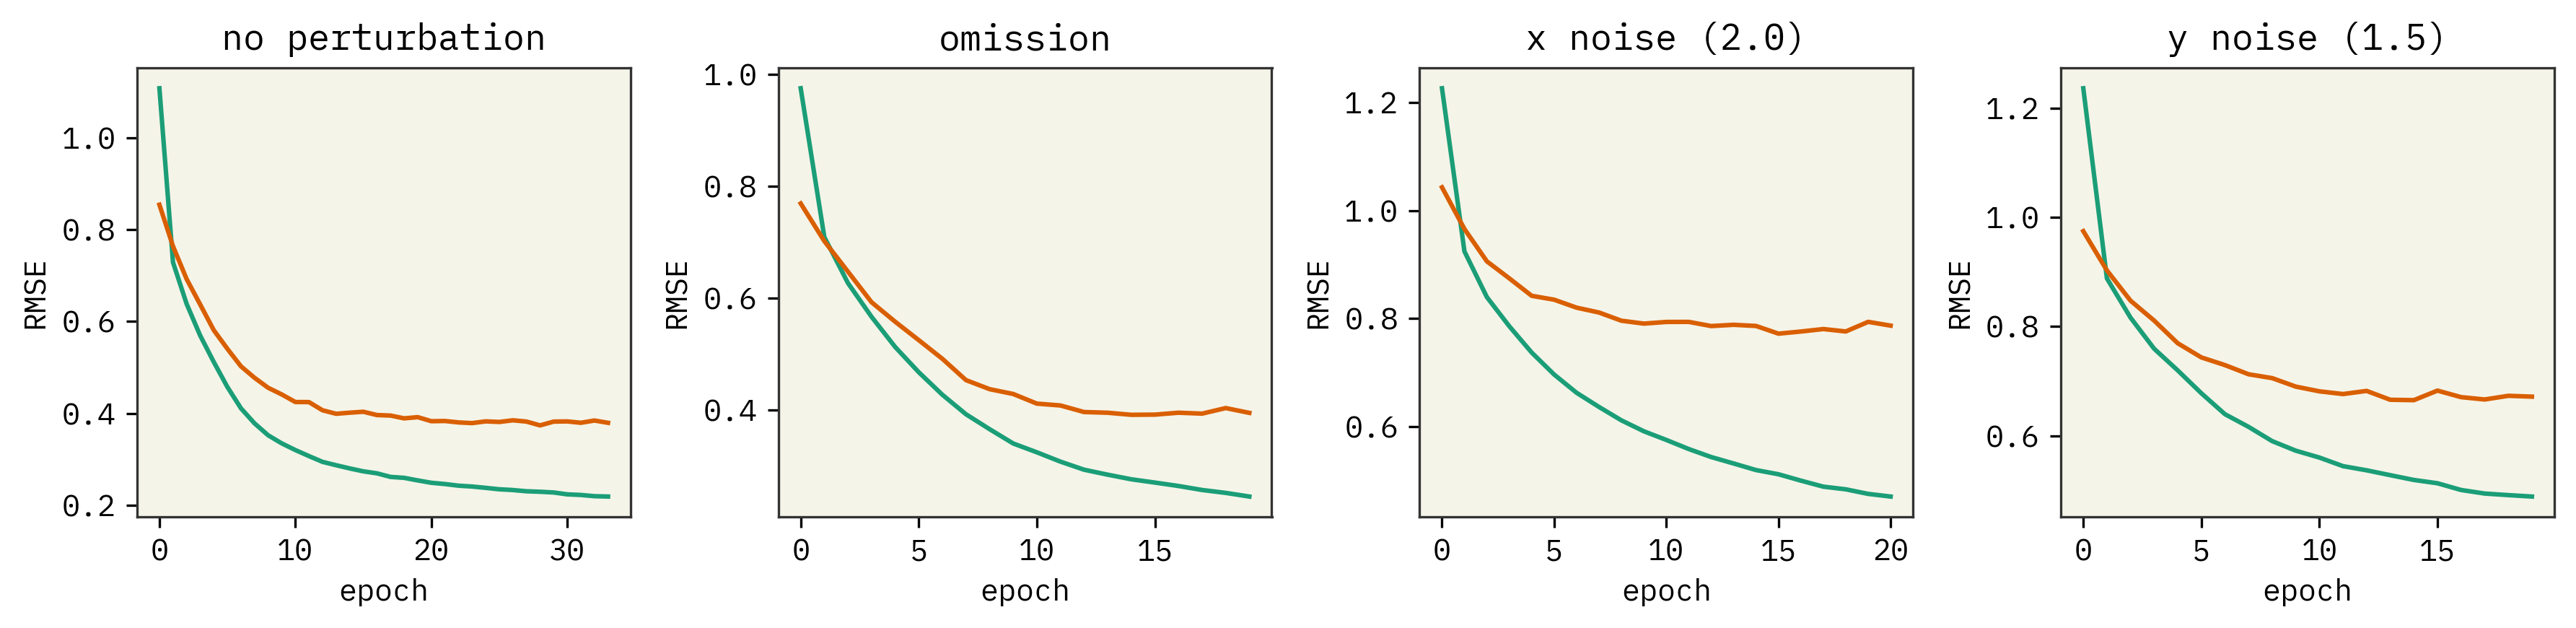

In [ ]:
plot_trainingcurves(tasks, main_results, figname="mlp_traincurves_earlystop.png")

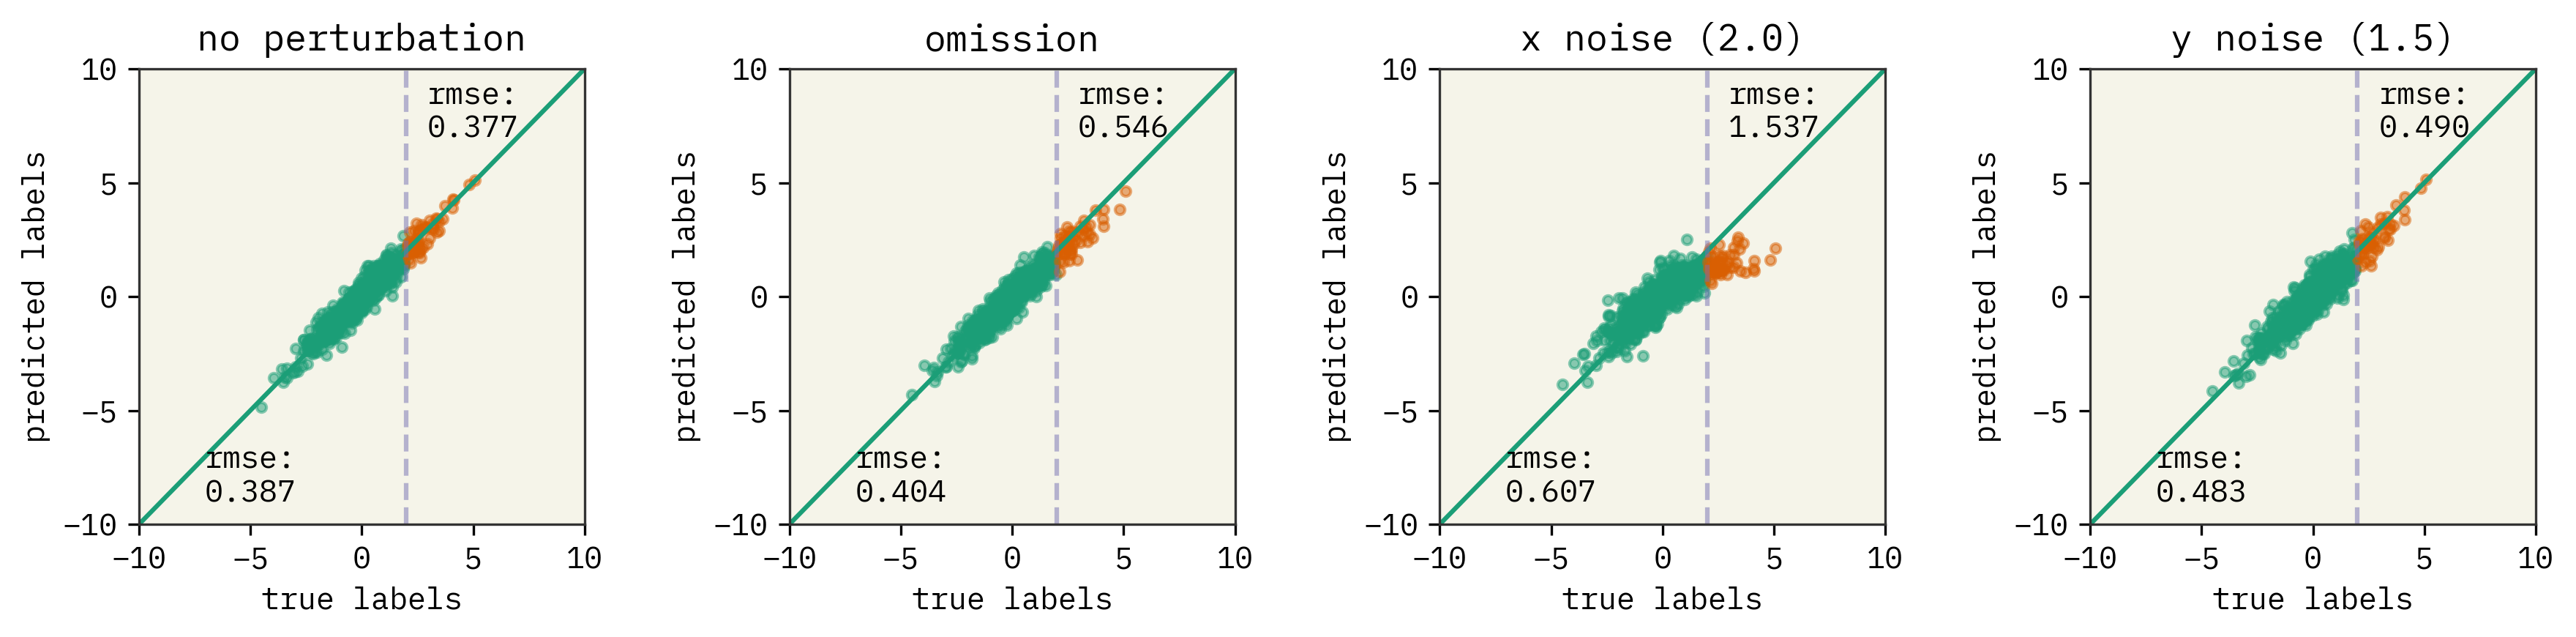

In [ ]:
plot_parityplots(tasks, main_results, threshold=2, figname="mlp_parityplots_earlystop.png")